# Hyperbolic K-Means Clustering
`Drew Wilimitis`

In this notebook, I apply hyperbolic k-means clustering to network data embedded in the Poincaré disk. To generate the embeddings, I use the poincare model provided by the `gensim` library. <br>

If class labels are also known for these networks datasets, a modified approach is used to perform supervised learning. K-means clustering is applied to a training set to partition the embedding space by ground truth labels, and then predictions are made on a separate test set by assigning the class label corresponding to the nearest centroid.   
<br>

**Note:** the poincare model embeds **unweighted**, **undirected** graphs.

### Algorithm Outline

Given data in the Poincare disk $x_1, \ldots , x_N \in \mathcal{B}^{d}$, partition the $N$ observations into k sets denoted by $\mathbf{S}=\left\{S_{1}, S_{2}, \ldots, S_{k}\right\}$, where we have $k$ centroids or means $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k}$ at each iteration $t$. <br>
<br>
The basic steps in Hyperbolic k-means are: <br>
1. **Initialization step**: initialize k random centroids $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k} \in \mathcal{B}^{d}$<br>
2. **Assignment step**: assign each $x_p$ to nearest centroid with smallest poincare distance<br>
3. **Project to H**: project to hyperboloid model<br>
4. **Update step**: calculate new means with optimization in Hyperboloid model <br>
5. **Project back to Poincare disk**: map back into poincare disk model
6. **Repeat steps 2-5 until stopping criteria** <br>
7. **Return:** cluster labels for all $x_i$ and cluster means $\left\{\boldsymbol{m}_{i}\right\}_{i=1}^{k}$

### Load libraries and helper functions

In [46]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import networkx as nx
import sys
import os

# import modules within repository
my_path = 'C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\utils' # path to utils folder
sys.path.append(my_path)
from utils import *
from hkmeans import HyperbolicKMeans, plot_clusters

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

## Enron Email Corpus

Organizational social network data based on email interaction among Enron employees<br>
108926 edges, 184 nodes, no class labels

In [47]:
# read in and clean enron email data
emails = pd.read_table('enron/emails.txt', delimiter=' ', header=None)
emails = emails[emails.iloc[:, 1] != emails.iloc[:, 2]].reset_index(drop=True)
emails.iloc[:, 1:].to_csv('enron/enron_relations.csv', index=False)
edge_list = []
for i in range(emails.shape[0]):
    edge_list.append(list(emails.iloc[i, 1:]))
employees = pd.read_csv('enron/employee_info.csv')
employees = employees.fillna('NA')

In [48]:
# load data with relation/graph edges (u,v)
#fp = 'enron/enron_relations.csv'
# train poincare embeddings and save output embed coordinates
#train_embeddings(input_path=fp, delimiter=',', output_path=os.path.join('models','enron_vectors'))

emb = pd.read_table('models/enron_vectors', delimiter=' ')
emb = emb.reset_index()
emb.columns = ['node', 'x', 'y']
emb_data = np.array(emb.iloc[:, 1:3])
emb_data.shape
names = employees['first'].values + ' ' + employees['last'].values
names = names + ' (' + employees['title'] + ')'
enron_dict = {}
for i in range(emb.shape[0]):
    enron_dict[names[i]] = emb_data[i]

(184, 2)

In [49]:
data = emb_data
hkmeans = HyperbolicKMeans(n_clusters=6)
hkmeans.fit(emb_data, max_epochs=10)
y = hkmeans.assignments
centroids = hkmeans.centroids

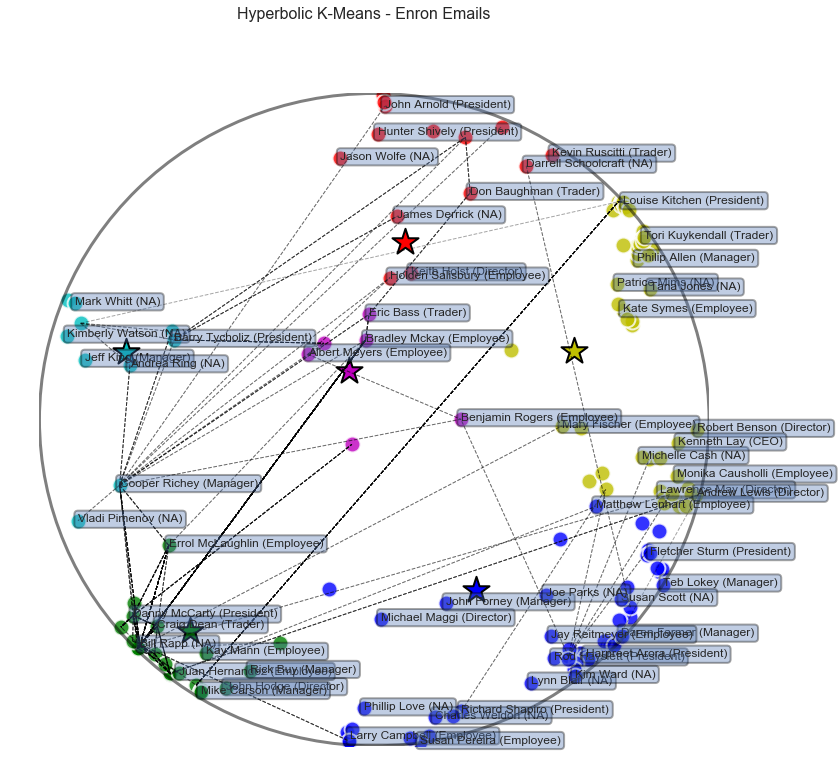

In [50]:
# plot results
plot_clusters(emb, y, centroids, edge_list, add_labels=True, label_dict=enron_dict,
              label_frac = 0.001, edge_frac = 0.01, width=12, height=12, title='Enron Emails')

## WordNET Mammals Subtree

In [51]:
# load data with relation/graph edges (u,v)
#fp = 'wordnet_mammal_hypernyms.tsv'
# train poincare embeddings and save output embed coordinates
#train_embeddings(input_path=fp, delimiter='\t', output_path=os.path.join('models','mammals_vectors'))

# Saves only the vectors from the PoincareModel instance, in the commonly used word2vec format
emb = pd.read_csv('models/mammals_vectors.csv', delimiter=' ')
emb = emb.reset_index()
x = emb.loc[:, '1182'].values
y = emb.loc[:, '2'].values
emb_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
emb_data.shape

(1182, 2)

In [52]:
data = emb_data
hkmeans = HyperbolicKMeans(n_clusters=6)
hkmeans.fit(emb_data, max_epochs=15)
y = hkmeans.assignments
centroids = hkmeans.centroids

mammal_dict = {}
mammals = emb['index'].values
label_dict = {}
for i in range(emb.shape[0]):
    label_dict[mammals[i]] = np.argmax(y[i])

for i in range(emb.shape[0]):
    mammal_dict[mammals[i]] = emb_data[i]

In [53]:
def dist_squared(x, y, axis=None):
    return np.sum((x - y)**2, axis=axis)

def plot_embedding(embedding_dict, label_frac=0.001, plot_frac=0.6, title=None, 
                   save_fig=False):
    colors = ['b', 'g', 'r', 'y', 'm', 'c', 'k', 'w']
    fig = plt.figure(figsize=(9,9))
    plt.grid('off')
    plt.xlim([-1.2,1.2])
    plt.ylim([-1.2,1.2])
    plt.axis('off')
    ax = plt.gca()
    embed_vals = np.array(list(embedding_dict.values()))
    #plt.xlim([embed_vals.min(0)[0],embed_vals.max(0)[0]])
    #plt.ylim([embed_vals.min(0)[1],embed_vals.max(0)[1]])
    keys = list(embedding_dict.keys())
    min_dist_2 = label_frac * max(embed_vals.max(axis=0) - embed_vals.min(axis=0)) ** 2
    labeled_vals = np.array([2*embed_vals.max(axis=0)])
    groups = [keys[i] for i in np.argsort(np.linalg.norm(embed_vals, axis=1))][:10]
    groups.insert(0, 'mammal.n.01')
    for key in groups:
        if np.min(dist_squared(embedding_dict[key], labeled_vals, axis=1)) < min_dist_2:
            continue
        else:
            _ = ax.scatter(embedding_dict[key][0], embedding_dict[key][1], s=40, c=colors[label_dict[key]])
            props = dict(boxstyle='round', lw=2, edgecolor='black', alpha=0.5)
            _ = ax.text(embedding_dict[key][0], embedding_dict[key][1]+0.01, s=key.split('.')[0], 
                        size=10, fontsize=12, verticalalignment='top', bbox=props)
            labeled_vals = np.vstack((labeled_vals, embedding_dict[key]))
    n = int(plot_frac*len(embed_vals))
    for i in np.random.permutation(len(embed_vals))[:n]:
        _ = ax.scatter(embed_vals[i][0], embed_vals[i][1], s=40, c=colors[label_dict[keys[i]]])
        if np.min(dist_squared(embed_vals[i], labeled_vals, axis=1)) < min_dist_2:
            continue
        else:
            _ = ax.text(embed_vals[i][0], embed_vals[i][1]+0.02, s=keys[i].split('.')[0], 
                        size=9, fontsize=11, verticalalignment='top', bbox=props)
            labeled_vals = np.vstack((labeled_vals, embed_vals[i]))
    if title != None:
        plt.title(title, size=16)
    if save_fig:
        plt.savefig('../images/mammals_kmeans.png')
    plt.show();

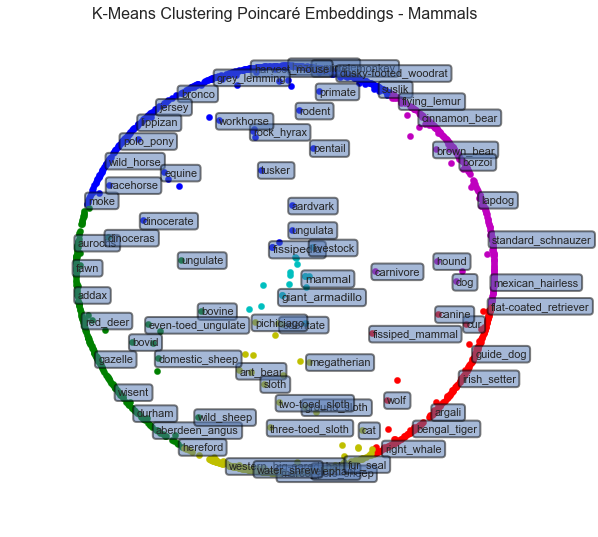

In [54]:
plot_embedding(mammal_dict, plot_frac=1, label_frac=0.003,
               title='K-Means Clustering Poincaré Embeddings - Mammals', save_fig=False)

# Supervised Learning Examples

We now adapt the hyperbolic KMeans algorithm for supervised learning, where the K centroids are produced by a random training subset and classification predictions are made on a separate holdout test set. 

##  Zachary karate club network

Undirected graph connecting members (nodes) of a karate club <br>
34 nodes, 78 edges, split into 2 different classes

In [115]:
# load original file to get edge list
karate_df = pd.read_csv('../data/ucidata-zachary/out.tsv', delimiter=' ', header=None)
edge_list = []
for i in range(karate_df.shape[0]):
    edge_list.append(list(karate_df.iloc[i, :]))
num_nodes = len(np.unique(karate_df))
num_edges = karate_df.shape[0]
print('Total nodes: {}\nTotal edges: {}'.format(num_nodes, num_edges))

Total nodes: 34
Total edges: 78


In [116]:
# load data with relation/graph edges (u,v)
fp = '../data/ucidata-zachary/out.tsv'
# train poincare embeddings and save output embed coordinates
train_embeddings(input_path=fp, delimiter=' ', output_path=os.path.join('models','karate_vectors'))

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 78 relations from train data, 34 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 78 relations for 100 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=10
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:burn-in finished
INFO:gensim.models.poincare:starting training (100 epochs)----------------------------------------
INFO:gensim.models.poincare:training finished
INFO:gensim.models.utils_any2vec:storing 34x2 projection weights into models\karate_vectors


Cluster variance:  1.4920416704205746
Inertia (poincaré dist):  48.14415192577504


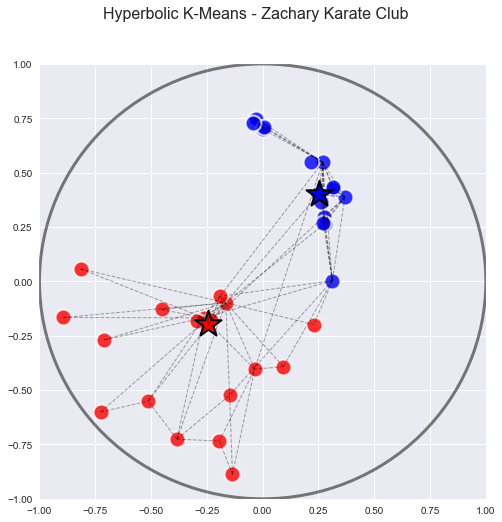

In [117]:
# load embedding vectors
emb = pd.read_table('models/karate_vectors', delimiter=' ')
emb = emb.reset_index()
emb.columns = ['node', 'x', 'y']
emb_data = np.array(emb.iloc[:, 1:3])

# fit hyperbolic kmeans and plot results
hkmeans = HyperbolicKMeans(n_clusters=2)
hkmeans.fit(emb_data, max_epochs=15)
y = hkmeans.assignments
centroids = hkmeans.centroids
print('Cluster variance: ', hkmeans.variances)
print('Inertia (poincaré dist): ', hkmeans.inertia_)
plot_clusters(emb, y, centroids, edge_list, 'Zachary Karate Club')

In [120]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, zero_one_loss
from sklearn.model_selection import train_test_split

# true class labels (from An Information Flow Model for Conflict and Fission in Small Groups (1977))
y_true = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
          1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1])
y_true = y_true[emb.node.values - 1]
X = emb_data
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.35) 

In [121]:
kmeans_clf = HyperbolicKMeans(n_clusters=2)
kmeans_clf.fit(X_train, y_train)
y_pred = np.argmax(kmeans_clf.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(zero_one_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

1.0
0.0


### NCAA football teams

614 undirected edges, 117 NCAA teams (nodes), 12 classes 

In [104]:
# load graph data from networkx
G = nx.read_gml('football/football.gml', label='id')
football_df = pd.DataFrame(np.array(list(G.edges())), columns=['u', 'v'])
football_df.to_csv('football/football_relations.csv', index=False)
edge_list = []
for i in range(football_df.shape[0]):
    edge_list.append(list(football_df.iloc[i, :]))
num_nodes = len(np.unique(football_df))
num_edges = football_df.shape[0]
print('Total nodes: {}\nTotal edges: {}'.format(num_nodes, num_edges))

Total nodes: 115
Total edges: 613


In [105]:
# load data with relation/graph edges (u,v)
#fp = 'football/football_relations.csv'
# train poincare embeddings and save output embed coordinates
#train_embeddings(input_path=fp, delimiter=',', output_path=os.path.join('models','football_vectors'))

# load pre-trained embedding coordinates
emb = pd.read_csv('models/football_vectors', delimiter=' ')
emb = emb.reset_index()
emb.columns = ['node', 'x', 'y']
# drop last two garbage rows
emb = emb.iloc[:-2, :]
emb['node'] = emb.node.astype('int')
emb = emb.sort_values(by='node').reset_index(drop=True)
emb_data = np.array(emb.iloc[:, 1:3])
emb_data.shape

(115, 2)

In [106]:
# fit hyperbolic kmeans 
data = emb_data
hkmeans = HyperbolicKMeans(n_clusters=12)
hkmeans.fit(emb_data, max_epochs=7)
y = hkmeans.assignments
centroids = hkmeans.centroids

In [107]:
# get team name labels with embedding coords
G = nx.read_gml('football/football.gml', label='id')
teams = []
for i in range(emb.shape[0]):
    teams.append(G.node[i]['label'])
ncaa_labels = []
for i in range(emb.shape[0]):
    ncaa_labels.append(G.node[i]['value'])
teams = np.array(teams)
ncaa_labels = np.array(ncaa_labels)

football_dict = {}
label_dict = {}
for i in range(emb.shape[0]):
    label_dict[teams[i]] = np.argwhere(y[i] == 1)[0][0]

for i in range(emb.shape[0]):
    football_dict[teams[i]] = emb_data[i]

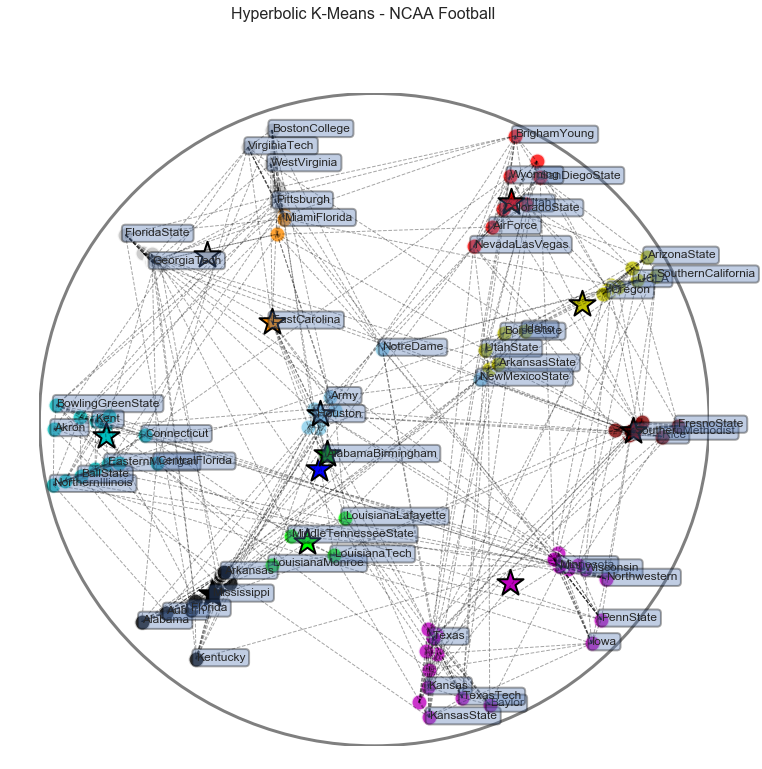

In [108]:
# plot results
plot_clusters(emb, y, centroids, edge_list, add_labels=True, label_dict=football_dict,
              label_frac = 0.001, width=12, height=12, title='NCAA Football')

In [113]:
# true class labels 
y_true = ncaa_labels
y_true = y_true[emb.node.values.astype('int')]
X = emb_data
# fit clustering
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2) 
kmeans_clf = HyperbolicKMeans(n_clusters=12)
kmeans_clf.fit(X_train, y_train)

In [114]:
# evaluate predictions
y_pred = np.argmax(kmeans_clf.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(zero_one_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       0.67      1.00      0.80         2
           5       0.00      0.00      0.00         3
           6       0.33      1.00      0.50         1
           7       0.00      0.00      0.00         2
           8       1.00      0.67      0.80         3
           9       0.67      1.00      0.80         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         3

   micro avg       0.57      0.57      0.57        23
   macro avg       0.47      0.57      0.49        23
weighted avg       0.52      0.57      0.53        23

0.5652173913043478
0.4347826086956522


## Polbooks

In [131]:
pollbooks_df = pd.read_table('pollbooks/out.dimacs10-polbooks', delimiter='\t')
pollbooks_df = pollbooks_df.reset_index()
u = pollbooks_df.iloc[:, 0]
v = pollbooks_df.iloc[:, 1]
pollbooks_df.shape
pollbooks_df.columns = ['u', 'v']
edge_list = []
for i in range(pollbooks_df.shape[0]):
    edge_list.append(list(pollbooks_df.iloc[i, :]))
pollbooks_df.to_csv('pollbooks_relations.csv', index=False)

(441, 2)

In [145]:
# load data with relation/graph edges (u,v)
#fp = 'pollbooks/pollbooks_relations.csv'
# train poincare embeddings and save output embed coordinates
#train_embeddings(input_path=fp, delimiter=',', output_path=os.path.join('models','pollbooks_vectors'))

# load pre-trained embedding coordinates
emb = pd.read_csv('models/pollbooks_vectors', delimiter=' ')
emb = emb.reset_index()
emb.columns = ['node', 'x', 'y']
# drop last two garbage rows
emb = emb.iloc[:-2, :]
emb['node'] = emb.node.astype('int')
emb = emb.sort_values(by='node').reset_index(drop=True)
emb_data = np.array(emb.iloc[:, 1:3])
emb_data.shape

(105, 2)

In [146]:
data = emb_data
hkmeans = HyperbolicKMeans(n_clusters=3)
hkmeans.fit(data, max_epochs=15)
y = hkmeans.assignments
centroids = hkmeans.centroids

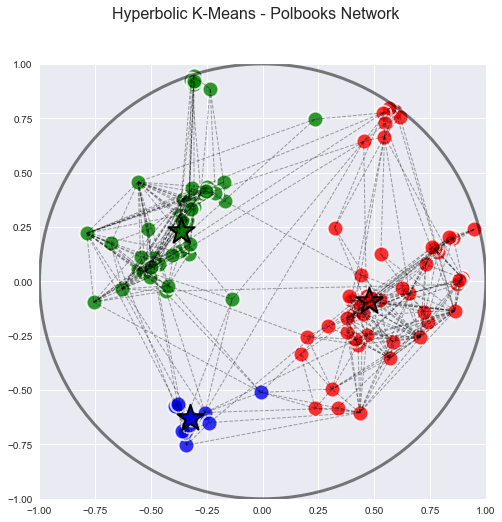

In [147]:
plot_clusters(emb, y, centroids, edge_list, 'Polbooks Network')

In [148]:
G = nx.read_gml('pollbooks/polbooks.gml.txt', label='id')
labels = []
for i in range(emb.shape[0]):
    labels.append(G.node[i]['value'])
labels = np.array(labels)
class_map = {'n': 0, 'c': 1, 'l': 2}
polbook_labels = np.array([class_map[x] for x in labels])

In [149]:
# true class labels (from An Information Flow Model for Conflict and Fission in Small Groups (1977))
y_true = polbook_labels
y_true = y_true[emb.node.values.astype('int')-1]
X = emb_data
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.25) 
kmeans_clf = HyperbolicKMeans(n_clusters=3)
kmeans_clf.fit(X_train, y_train)

In [150]:
y_pred = np.argmax(kmeans_clf.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(zero_one_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.17      0.33      0.22         3
           1       0.87      1.00      0.93        13
           2       1.00      0.55      0.71        11

   micro avg       0.74      0.74      0.74        27
   macro avg       0.68      0.63      0.62        27
weighted avg       0.84      0.74      0.76        27

0.7407407407407407
0.2592592592592593


In [120]:
#from IPython.core.display import HTML

#def css_styling():
#    styles = open("../custom_style.css", "r").read()
#    return HTML(styles)
#css_styling()

## References
---

[1]. Learning graph-structured data using Poincaré embeddings and Riemannian K-means algorithms. Hatem Hajri, Hadi Zaatiti, Georges Hebrail. https://arxiv.org/abs/1907.01662.<br>
[2]. Begelfor, Evgeni and Michael Werman. “The World is not always Flat or Learning Curved Manifolds.” (2005).<br>
[3]. Wilson, Benjamin R. and Matthias Leimeister. “Gradient descent in hyperbolic space.” (2018).